# First we try and recreate the original Jursik and Kovac equation

In [ ]:
import blink_util

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import RocCurveDisplay

data = pd.read_csv("Jurcsik_Kovacs_1996_table1.csv")


# data filter

#set A params to ratios of A1
df = data.drop(columns=["star_name","shifted_data","A0", "N"])

df

,period,sigma,A1,phi1,A2,phi2,A3,phi3,A4,phi4,...,phi11,A12,phi12,A13,phi13,a14,phi14,A15,phi15,metallicity
0,0.442266,0.0091,0.3218,0.0179,0.1803,2.6140,0.1057,5.4850,0.0590,2.0787,...,5.5635,0.0044,1.9820,0.0058,4.6203,0.0051,0.7701,0.0044,3.6286,-0.06
1,0.722753,0.0155,0.3358,1.6476,0.1720,5.9663,0.1134,4.0763,0.0617,2.5336,...,1.7614,0.0006,1.7596,0.0013,0.5223,0.0011,5.6820,0.0012,4.6372,-1.69
2,0.616915,0.0141,0.2000,1.5871,0.0795,5.8195,0.0399,3.9177,0.0192,2.1835,...,3.6049,0.0008,1.2567,0.0009,5.3117,0.0007,3.8731,0.0008,1.9359,-0.92
3,0.574337,0.0184,0.3241,2.9349,0.1425,1.9110,0.1110,1.1494,0.0745,0.5286,...,4.1754,0.0048,3.5231,0.0061,3.0121,0.0056,2.3907,0.0050,1.7239,-1.39
4,0.459303,0.0180,0.4646,1.8951,0.2167,6.0193,0.1610,4.1492,0.0980,2.3481,...,2.3529,0.0080,0.6458,0.0050,5.6980,0.0048,2.3401,0.0009,0.6272,-1.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.557657,0.0135,0.3281,2.9453,0.1658,1.9827,0.1162,1.4013,0.0748,0.8343,...,4.8732,0.0038,4.3968,0.0046,3.8138,0.0050,3.2229,0.0051,2.6125,-1.15
80,0.475607,0.0139,0.3756,1.3720,0.2054,5.1373,0.1310,2.9590,0.0938,0.8321,...,3.3662,0.0046,0.6953,0.0034,4.6167,0.0018,2.0494,0.0011,5.7768,-0.60
81,0.525791,0.0377,0.4131,4.8677,0.1731,5.7203,0.1417,0.3700,0.1022,1.5990,...,2.7926,0.0102,3.8922,0.0096,5.0910,0.0088,0.0597,0.0077,1.3509,-1.54
82,0.656908,0.0184,0.2718,0.7286,0.1335,4.0737,0.0822,1.4576,0.0426,5.1255,...,0.8733,0.0028,4.4377,0.0014,1.3375,0.0010,4.4196,0.0009,1.7312,-1.02


# We now evaluate the relationship between parameters
We'll begin by setting up a new DF with the appropriate parameters

## R_sub_N1N2
We want the ratios between alphas as we don't want distance to affect our weights

In [ ]:
jk_df = pd.DataFrame()


# Get ratios e.x. A1/A2, A1/A3 etc.
phi_filter = df.filter(["A1","A2","A3"])
for phi_n1 in phi_filter.columns:

    for phi_n2 in phi_filter.drop(columns=[phi_n1]).columns:
        ratio_name = f"R_{phi_n1[1:]}{phi_n2[1:]}"

        # append ratios
        jk_df[ratio_name] = phi_filter[phi_n1].to_numpy() / phi_filter[phi_n2].to_numpy()

jk_df

,R_12,R_13,R_21,R_23,R_31,R_32
0,1.784803,3.044465,0.560286,1.705771,0.328465,0.586245
1,1.952326,2.961199,0.512210,1.516755,0.337701,0.659302
2,2.515723,5.012531,0.397500,1.992481,0.199500,0.501887
3,2.274386,2.919820,0.439679,1.283784,0.342487,0.778947
4,2.143978,2.885714,0.466423,1.345963,0.346535,0.742963
...,...,...,...,...,...,...
79,1.978890,2.823580,0.505334,1.426850,0.354160,0.700844
80,1.828627,2.867176,0.546858,1.567939,0.348775,0.637780
81,2.386482,2.915314,0.419027,1.221595,0.343016,0.818602
82,2.035955,3.306569,0.491170,1.624088,0.302428,0.615730


## Phi_sub_N1N2
We get the values for Phi parameters to measure their weights

In [ ]:
phi_filter = df.filter(["phi1","phi2","phi3"])
for phi_n1 in phi_filter.columns:

    for phi_n2 in phi_filter.drop(columns=[phi_n1]).columns:
        ratio_name = f"Phi{phi_n2[3:]}{phi_n1[3:]}"

        phi_n1_row = phi_filter[phi_n1].to_numpy()
        phi_n2_row = phi_filter[phi_n2].to_numpy()

        coef = int(phi_n1[3:])



        # append ratios
        jk_df[ratio_name] = blink_util.twopi_normalize(phi_n1_row,phi_n2_row,coef=coef)

jk_df

,R_12,R_13,R_21,R_23,R_31,R_32,Phi21,Phi31,Phi12,Phi32,Phi13,Phi23
0,1.784803,3.044465,0.560286,1.705771,0.328465,0.586245,2.6140,5.4850,0.0179,5.4850,0.0179,2.6140
1,1.952326,2.961199,0.512210,1.516755,0.337701,0.659302,5.9663,4.0763,1.6476,4.0763,1.6476,5.9663
2,2.515723,5.012531,0.397500,1.992481,0.199500,0.501887,5.8195,3.9177,1.5871,3.9177,1.5871,5.8195
3,2.274386,2.919820,0.439679,1.283784,0.342487,0.778947,1.9110,1.1494,2.9349,1.1494,2.9349,1.9110
4,2.143978,2.885714,0.466423,1.345963,0.346535,0.742963,6.0193,4.1492,1.8951,4.1492,1.8951,6.0193
...,...,...,...,...,...,...,...,...,...,...,...,...
79,1.978890,2.823580,0.505334,1.426850,0.354160,0.700844,1.9827,1.4013,2.9453,1.4013,2.9453,1.9827
80,1.828627,2.867176,0.546858,1.567939,0.348775,0.637780,5.1373,2.9590,1.3720,2.9590,1.3720,5.1373
81,2.386482,2.915314,0.419027,1.221595,0.343016,0.818602,5.7203,0.3700,4.8677,0.3700,4.8677,5.7203
82,2.035955,3.306569,0.491170,1.624088,0.302428,0.615730,4.0737,1.4576,0.7286,1.4576,0.7286,4.0737


In [3]:
X = df.drop("metallicity", axis=1) #Independent Variables. Doesn't Include Metalicity.

y = df["metallicity"] #Dependent Variable. Includes Metalicity.

#Providing Data for Regression.

In [4]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

model = LinearRegression() #Defining "Model". Creating an instance of class LinearRegression.
model.fit(x_train, y_train) #Adjusting the model's internal parameters. 
#Calculating optimal values for weights.
#Creating the regressional model.

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


# Display weight of each parameter

In [5]:
coefficients = model.coef_
intercept = model.intercept_


coef_df = pd.DataFrame({'Params': list(X), 'Coefficients':coefficients})
coef_df

#Creating a table of what predicted weights are being attahced to each independent variable.

,Params,Coefficients
0,period,-5.037124
1,sigma,-8.461776
2,A1,-5.023414
3,phi1,0.015373
4,A2,8.864586
5,phi2,-0.037964
6,A3,-10.326533
7,phi3,0.037306
8,A4,17.240273
9,phi4,-0.016869


# Predict metallicity and display predicted values v. actual values

Mean Absolute Error (MEA): 0.30455215722807594
Mean Squared Error (MRE): 0.12501379163666576
R^2 Score: 0.5131670997961516


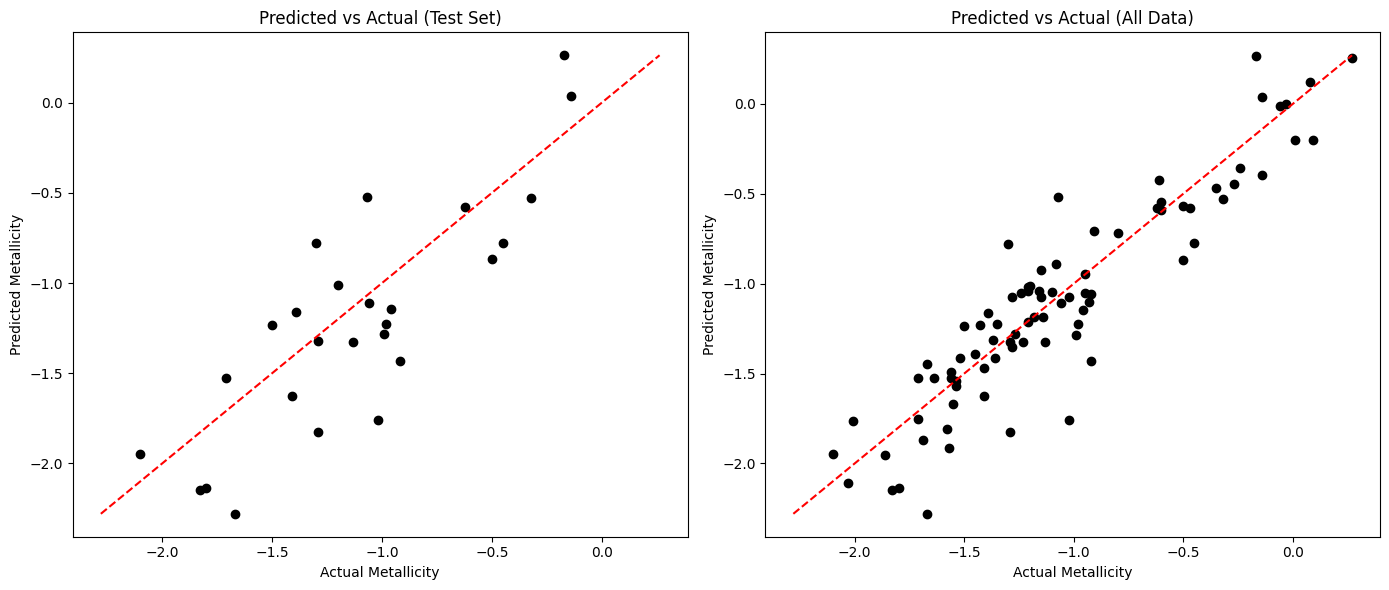

In [6]:
y_predict_test = model.predict(x_test)
y_predict_all = model.predict(X)

print(f"Mean Absolute Error (MEA): {mean_absolute_error(y_test, y_predict_test)}")

print(f"Mean Squared Error (MRE): {mean_squared_error(y_test, y_predict_test)}")

print(f"R^2 Score: {model.score(x_test, y_test)}")



fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(y_test, y_predict_test, color="black")
lims_test = [
    min(y_test.min(), y_predict_test.min()), max(y_test.max(), y_predict_test.max())
    ]
axes[0].plot(lims_test, lims_test, 'r--')
axes[0].set_xlabel("Actual Metallicity")
axes[0].set_ylabel("Predicted Metallicity")
axes[0].set_title("Predicted vs Actual (Test Set)")


axes[1].scatter(y, y_predict_all, color="black")
lims_all = [min(y.min(), y_predict_all.min()), max(y.max(), y_predict_all.max())]
axes[1].plot(lims_all, lims_all, 'r--')
axes[1].set_xlabel("Actual Metallicity")
axes[1].set_ylabel("Predicted Metallicity")
axes[1].set_title("Predicted vs Actual (All Data)")

plt.tight_layout()
plt.show()

#Setting up Predicted vs. Actual for test data and the full set.

[0.4422659  0.7227526  0.61691475 0.5743365  0.4593029  0.53571327
 0.5711943  0.6940186  0.4818785  0.463407   0.6337525  0.3617869
 0.57802054 0.65115973 0.3916739  0.53227327 0.570916   0.7371495
 0.367345   0.55176012 0.52121    0.55302877 0.573687   0.5106085
 0.5866133  0.5895     0.41201385 0.47261818 0.66042002 0.569671
 0.5920785  0.58830638 0.58724751 0.713798   0.5699005  0.6053397
 0.39730816 0.550303   0.5482104  0.39959991 0.4553728  0.44032773
 0.478639   0.488998   0.636651   0.4523926  0.653418   0.6263438
 0.4779843  0.672843   0.598653   0.54393    0.68432461 0.5814775
 0.26962398 0.5339377  0.5974332  0.577122   0.440905   0.57116658
 0.4503564  0.3970232  0.557163   0.4539182  0.7103756  0.46844376
 0.390376   0.42554892 0.4403703  0.5297291  0.4805468  0.47747883
 0.7140962  0.52207211 0.7465682  0.4875571  0.374039   0.642237
 0.635021   0.557657   0.47560652 0.5257915  0.656908   0.405438  ]


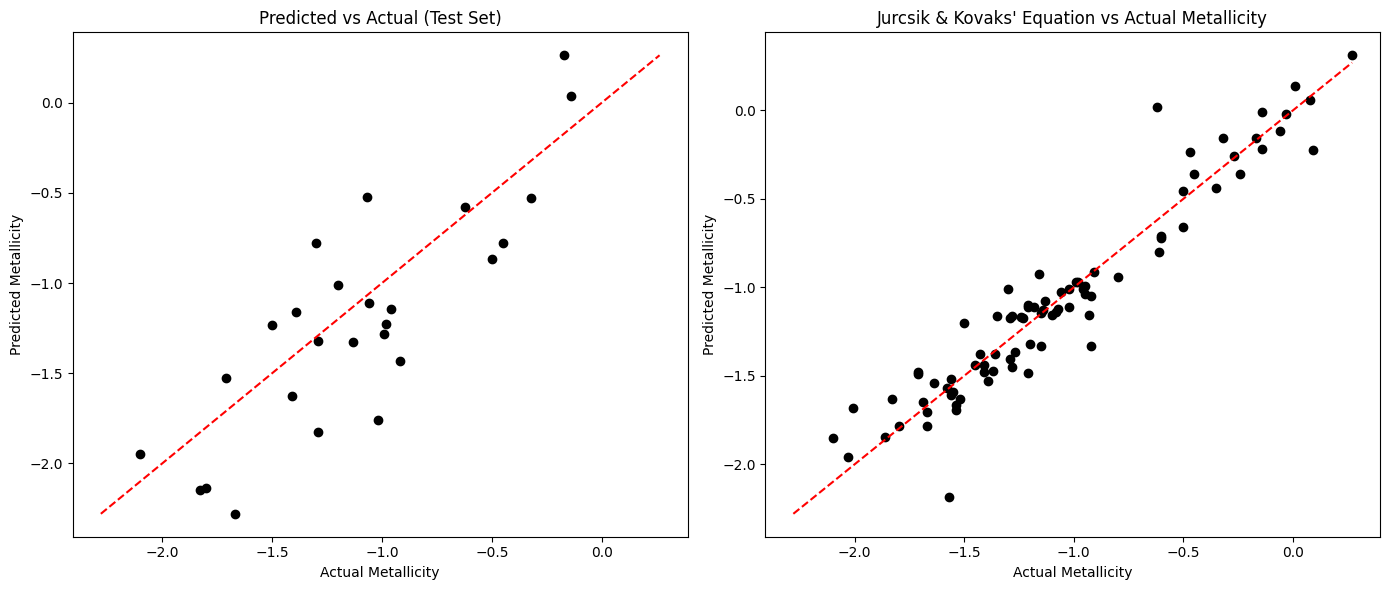

In [ ]:
Fe_on_H = blink_util.get_FoH(df, verbose=False)


fig, axes = plt.subplots(1, 2, figsize=(14, 6))



axes[0].scatter(y_test, y_predict_test, color="black")
lims_test = [
    min(y_test.min(), y_predict_test.min()), max(y_test.max(), y_predict_test.max())
    ]
axes[0].plot(lims_test, lims_test, 'r--')
axes[0].set_xlabel("Actual Metallicity")
axes[0].set_ylabel("Predicted Metallicity")
axes[0].set_title("Predicted vs Actual (Test Set)")

axes[1].scatter(y, Fe_on_H, color="black")
lims_all = [min(y.min(), y_predict_all.min()), max(y.max(), y_predict_all.max())]
axes[1].plot(lims_all, lims_all, 'r--')
axes[1].set_xlabel("Actual Metallicity")
axes[1].set_ylabel("Predicted Metallicity")
axes[1].set_title("Jurcsik & Kovaks' Equation vs Actual Metallicity")

plt.tight_layout()
plt.show()

#Axes = Axis'.
#Creating plots and setting labels.
#Checking results.

# Cross Validation
Here we use KFold and CV to measure the accuracy of the model

First we get the score for our first estimator

In [8]:
score = cross_validate(model, X, y, cv=5, verbose=0)
print(f"CV Scores: {score['test_score']}")

CV Scores: [0.73953756 0.66850209 0.44433683 0.76533173 0.66016911]


Now we train our model using KFold splits with shuffled items and measure the scores

In [9]:
kfold = KFold(n_splits=5, shuffle=True)

score = cross_val_score(model, X, y, cv=kfold, verbose=0)
print(f"KFold split=5 Scores: {score}\n Mean KFold Score: {score.mean()}")

KFold split=5 Scores: [0.67967844 0.6169067  0.70901273 0.73228337 0.75192988]
 Mean KFold Score: 0.6979622232981801


# Equations

# 

In [10]:
#Attempt to get equation

m = model.coef_[0]      # slope
b = model.intercept_   # y-intercept

print(f"y = {m:.4f}x + {b:.4f}")

for i, coef in enumerate(model.coef_):
    print(f"b{i+1} = {coef}")

y = -5.0371x + 3.4338
b1 = -5.037124323551887
b2 = -8.461775750075095
b3 = -5.023413793631357
b4 = 0.01537272547087899
b5 = 8.864585994408403
b6 = -0.037964162203326095
b7 = -10.326533295442475
b8 = 0.037305912358725275
b9 = 17.240273168241565
b10 = -0.016869093196117083
b11 = -33.08705960930392
b12 = -0.04484407851723088
b13 = 62.27291338715759
b14 = -0.03718616629361915
b15 = -40.58391777115427
b16 = -0.02484533748112445
b17 = -10.265809689621166
b18 = -0.03413233772325963
b19 = 26.19903081365732
b20 = -0.024509743904767345
b21 = -75.32219977546237
b22 = -0.028137480159351913
b23 = 48.919303503144874
b24 = 0.0034861414058615647
b25 = -20.334432413069546
b26 = -0.02861989614739957
b27 = -10.548369533533712
b28 = -0.030059689556492852
b29 = 74.80210986606262
b30 = -0.00634160041328391
b31 = -55.0609474402325
b32 = -0.007336577473609385
